<a href="https://colab.research.google.com/github/Achraf-Trabelsi/PFA-NLP/blob/main/BiLSTM_embed_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os 
import tensorflow as tf
from tensorflow import keras
from keras import layers
path='/content/drive/MyDrive/PFA/'
data=pd.read_csv(f'{path}dataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15594 entries, 0 to 15593
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      15594 non-null  object
 1   text    15594 non-null  object
 2   pos     15594 non-null  object
 3   arg     15594 non-null  object
dtypes: object(4)
memory usage: 487.4+ KB


In [ ]:
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts([text for text in data['text'].values])
vocab_size = len(t.word_index)+1

In [ ]:
max_seq_length=600

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

X = data[['text','pos']].values
y = data['arg'].values
pos = X[:,1]

X_encode = t.texts_to_sequences(X[:,0])
y=[np.array([float(x1) for x1 in x.split()]) for x in y]
pos=[np.array([float(x1) for x1 in x.split()]) for x in pos]

X_padded = pad_sequences(X_encode, maxlen=max_seq_length,padding='post')
pos_padded = pad_sequences(pos, maxlen=max_seq_length,padding='post',value=8)
y_padded = pad_sequences(y, maxlen=max_seq_length,padding='post',value=8)

pos_cat = np_utils.to_categorical(pos_padded)
y_cat = np_utils.to_categorical(y_padded)

In [ ]:
X.shape

(15594, 2)

In [ ]:
np.array(X_padded).shape

(15594, 600)

In [ ]:
np.array(pos_padded).shape

(15594, 600)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded,y_cat, test_size=0.2, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(pos_cat,y_cat, test_size=0.2, random_state=42)

In [ ]:
import urllib.request
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-06-02 22:01:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-02 22:01:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-02 22:01:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q -n "/content/glove.6B.zip" -d "/content/"
emmbed_dict = {}
with open('/content/glove.6B.50d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],dtype='float32')
    emmbed_dict[word]=vector

In [ ]:
embeddings_index = dict()
f = open('/content/glove.6B.50d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size,50))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
X_train.shape

(12475, 600)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.models import Model

def modelLSTM1(input_shape,input_length,internal_units,output_size,vocab_size,embedding_matrix=embedding_matrix,embedding_dim=50):
    input_lstm1 = layers.Input(shape=input_length)
    embedding = layers.Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length=input_length,trainable=False)(input_lstm1)
    lstm1 = layers.Bidirectional(layers.LSTM(units=internal_units,return_sequences=True))(embedding)
    input_lstm2 = layers.Input(shape=input_shape)
    lstm2 = layers.Bidirectional(layers.LSTM(input_shape=input_shape,units=internal_units,return_sequences=True))(input_lstm2)
    dense_input = layers.concatenate([lstm1,lstm2])
    output= layers.TimeDistributed(layers.Dense(output_size,activation='softmax'))(dense_input)
    model = Model(inputs=[input_lstm1,input_lstm2], outputs=output)
    return model

In [ ]:
model1 = modelLSTM1(input_shape=(X1_train.shape[1],X1_train.shape[2]),input_length=max_seq_length,internal_units=64,output_size=y_test.shape[2],vocab_size=vocab_size)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 600, 50)      3394400     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 600, 46)]    0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 600, 128)     58880       ['embedding[0][0]']              
                                                                                              

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history=model1.fit(x=[X_train, X1_train], y=y_train, batch_size=256, epochs=10, validation_data=([X_test, X1_test], y_test), verbose=1)

Epoch 1/10
49/49 [==============================] - 265s 5s/step - loss: 1.1077 - categorical_accuracy: 0.7004 - val_loss: 0.8522 - val_categorical_accuracy: 0.7294
Epoch 2/10
49/49 [==============================] - 253s 5s/step - loss: 0.7747 - categorical_accuracy: 0.7447 - val_loss: 0.7015 - val_categorical_accuracy: 0.7665
Epoch 3/10
49/49 [==============================] - 252s 5s/step - loss: 0.6809 - categorical_accuracy: 0.7707 - val_loss: 0.6659 - val_categorical_accuracy: 0.7750
Epoch 4/10
49/49 [==============================] - 252s 5s/step - loss: 0.6545 - categorical_accuracy: 0.7782 - val_loss: 0.6489 - val_categorical_accuracy: 0.7791
Epoch 5/10
49/49 [==============================] - 250s 5s/step - loss: 0.6418 - categorical_accuracy: 0.7821 - val_loss: 0.6392 - val_categorical_accuracy: 0.7820
Epoch 6/10
49/49 [==============================] - 263s 5s/step - loss: 0.6317 - categorical_accuracy: 0.7857 - val_loss: 0.6262 - val_categorical_accuracy: 0.7873
Epoch 7/10

In [ ]:
loss, accuracy = model1.evaluate([X_test, X1_test],  y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

98/98 [==============================] - 23s 234ms/step - loss: 0.6015 - categorical_accuracy: 0.7957
Accuracy: 79.569626


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
ydl_pred = np.argmax(model1.predict([X_test,X1_test]), axis=-1)
y_true = np.argmax(y_test,axis=-1)

In [ ]:
cm=[ f1_score(y_t,y_p,average='weighted') for y_t,y_p in zip(y_true,ydl_pred)]
np.mean(cm)

0.7703180975023891

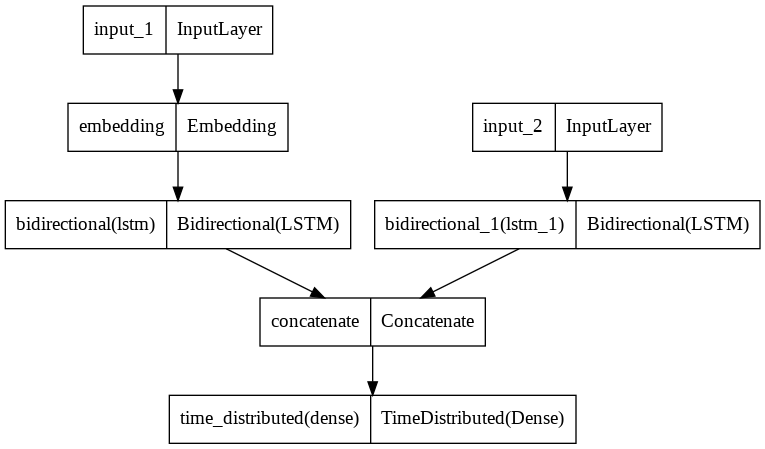

In [ ]:
tf.keras.utils.plot_model(model1, to_file='/content/drive/MyDrive/PFA/bilstm-epos.png')

In [ ]:
vocab_size

67888